In [1]:
import unicodedata
#from comet_ml import Experiment
import string
import re
import random
import time
import datetime
import math

import torch
import torch.nn as nn
from torch.nn import functional
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import io
import torchvision
from PIL import Image
import argparse

import os
import subprocess 
import pickle

import socket
import visdom

## Code Hyperparams

In [2]:
model_to_test = "bpe2char_3_121317__0.000121_1024_15_Bahdanau"
epoch_eval = 6000

In [3]:
#out_dir = "/scratch/eff254/NLP/MICA_NeuralMachineTranslation/EduTrials/FinalModels/checkpoints"
#out_dir = "/scratch/rds491/MICA_NeuralMachineTranslation/EduTrials/FinalModels/checkpoints" 
out_dir = "/scratch/mmd378/NLP_2017/cps_to_eval"
# If running things from Raul, getfacl on his checkpoints AND Evaluation folders. 

## Epoch for evaluation

In [4]:
def get_number(filename):
    
    number = re.split("_", filename, maxsplit=0, flags=0)[-1]
    number = re.split("[.]", number, maxsplit=0, flags=0)[0]
    
    try: 
        int(number)
        return int(number)
    except ValueError:
        return 0 # A filter for opt files
    
def get_max_iteration(): 

    files = os.listdir("{}/{}/".format(out_dir, model_to_test))
    iterations = [get_number(x) for x in files]
    
    return np.max(iterations)

if epoch_eval is not None: 
    epoch = epoch_eval 
else: 
    epoch = get_max_iteration()

## Setup

In [7]:
opt = pickle.load(open("{}/{}/model_opt.p".format(out_dir, model_to_test), "rb"))

PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.n_words = 4 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

def read_langs(lang1, lang2, set_type="train", term="txt", reverse=False, normalize=False):
    print("Reading lines...")

    # Read the file and split into lines
    if set_type == "train":
        filename = '%s/train/%s-%s.%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "dev":
        filename = '%s/dev/%s-%s.%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "valid":
        filename = '%s/dev/%s-%s.%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "tst2010":
        filename = '%s/test/%s-%s.tst2010-%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "tst2011":
        filename = '%s/test/%s-%s.tst2011-%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "tst2012":
        filename = '%s/test/%s-%s.tst2012-%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "tst2013":
        filename = '%s/test/%s-%s.tst2013-%s' % (opt.main_data_dir, lang1, lang2, term)
    elif set_type == "tst2014":
        filename = '%s/test/%s-%s.tst2014-%s' % (opt.main_data_dir, lang1, lang2, term)
    else:
        raise ValueError("set_type not found. Check data folder options")


    # lines contains the data in form of a list
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    if normalize == True:
        pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    else:
        pairs = [[s for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    return pairs

In [8]:
input_lang = pickle.load(open("{}/{}/input_lang.p".format(out_dir, model_to_test), "rb"))
output_lang = pickle.load(open("{}/{}/output_lang.p".format(out_dir, model_to_test), "rb"))

## Main model classes

In [9]:
###################################
# 3. Main model encoder - decoder #
###################################

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()

        self.input_size = input_size #no of words in the input Language
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)


    def forward(self, input_seqs, input_lengths, hidden=None): # hidden vector starts with zero (a guess!)

        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs) # size = (max_length, batch_size, embed_size). NOTE: embed_size = hidden size here
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths) # size = (max_length * batch_size, embed_size)

        outputs, hidden = self.gru(packed, hidden) # outputs are supposed to be probability distribution right?
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()

        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if opt.USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[b,:], encoder_outputs[i, b])

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)

    def score(self, hidden, encoder_output):

        if self.method == 'dot':
            # Used by Luong
            energy = hidden.squeeze(0).dot(encoder_output)
            return energy

        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy

        elif self.method == 'concat':
            # Used by Bahdanau
            energy = self.attn(torch.cat((hidden, encoder_output), 0))
            energy = (self.v.squeeze(0)).dot(energy)
            return energy

###############################
#  BAHDANAU_ATTN_DECODER_RNN  #
###############################

class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()

        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        ## 3. self.max_length = max_length
        ## self.max_length = opt.MAX_LENGTH

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)

        # Modifications made below in 2 lines
        self.gru = nn.GRU(2*hidden_size, hidden_size, n_layers, dropout=dropout_p)
        # self.out = nn.Linear(hidden_size * 2, output_size) # use of linear layer ?
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, word_input, last_hidden, encoder_outputs):

        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, word_input.data.shape[0], -1) # S=1 x B x N , ## N = hidden size (doubt)
        word_embedded = self.dropout(word_embedded)

        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N

        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2) # 1 x B x 2N (There seems to be a mistake here)
        output, hidden = self.gru(rnn_input, last_hidden)

        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(output))
        # output = F.log_softmax(self.out(torch.cat((output, context.squeeze(0)), 1)))
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

############################
#  LUONG_ATTN_DECODER_RNN  #
############################

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
            # Note: we run this one step at a time

            # Get the embedding of the current input word (last output word)
            batch_size = input_seq.size(0)
            embedded = self.embedding(input_seq)
            embedded = self.embedding_dropout(embedded)
            embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

            # Get current hidden state from input word and last hidden state
            rnn_output, hidden = self.gru(embedded, last_hidden)

            # Calculate attention from current RNN state and all encoder outputs;
            # apply to encoder outputs to get weighted average 

            attn_weights = self.attn(rnn_output.transpose(0, 1), encoder_outputs) # B*1*S encoder_outputs: S*B*emb
            context = attn_weights.bmm(encoder_outputs.transpose(0, 1)).squeeze(1)
            # Attentional vector using the RNN hidden state and context vector
            # concatenated together (Luong eq. 5)        
            rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
            # context = context.squeeze(1)       # B x S=1 x N -> B x N
            concat_input = torch.cat((rnn_output, context), 1)
            concat_output = F.tanh(self.concat(concat_input))

            # Finally predict next token (Luong eq. 6, without softmax & logsigmoid)
            output = F.logsigmoid(self.out(concat_output))

            # Return final output, hidden state, and attention weights (for visualization)
            return output, hidden, attn_weights

encoder = EncoderRNN(input_lang.n_words, opt.hidden_size, opt.n_layers, dropout=opt.dropout)

if opt.attention == 'Luong':
    decoder = LuongAttnDecoderRNN('dot', opt.hidden_size, output_lang.n_words, opt.n_layers, dropout=opt.dropout)
elif opt.attention == 'Bahdanau':
    decoder = BahdanauAttnDecoderRNN( opt.hidden_size, output_lang.n_words, opt.n_layers, dropout_p=opt.dropout)
else: 
    raise ValueError('Attention not found: Options are Luong or Bahdanau')   
    
if opt.USE_CUDA:
    encoder.cuda()
    decoder.cuda()

print("Loading/Updating encoder state dict at epoch {}".format(epoch))
enc_state = torch.load("{}/{}/saved_encoder_{}.pth".format(out_dir, model_to_test, epoch))
encoder.load_state_dict(enc_state)

print("Loading/Updating decoder state dict at epoch {}".format(epoch))
dec_state = torch.load("{}/{}/saved_decoder_{}.pth".format(out_dir, model_to_test, epoch))
decoder.load_state_dict(dec_state)

Loading/Updating encoder state dict at epoch 6000
Loading/Updating decoder state dict at epoch 6000


## Valuation framework

In [10]:
def indexes_from_sentence(lang, sentence):
    try:
        val = [lang.word2index[word] for word in sentence.split(' ')]
    except KeyError:
        # Do it individually. Means one word is not on dictionary:
        val = []
        for word in sentence.split(' '):
            try:
                indexed = lang.word2index[word]
                val.append(indexed)
            except KeyError:
                val.append(3)

    return val + [EOS_token]

def update_dictionary(target_sequence, topv, topi, key, dec_hidden, decoder_attns):
    if len(target_sequence) == 0:
        for i in range(len(topi)):
            target_sequence.update({str(topi[i]) : [topv[i], dec_hidden, decoder_attns] })
    else:
        prev_val = target_sequence[key][0]
        for i in range(len(topi)):
            target_sequence.update({key+"-"+str(topi[i]) : [topv[i]+prev_val, dec_hidden, decoder_attns] })
        del[target_sequence[key]]


def get_seq_through_beam_search(max_length, decoder, decoder_input, decoder_hidden, decoder_attentions, encoder_outputs, kmax ):

    target_sequence = dict()
    # Run through decoder
    for di in range(max_length):

        if di == 0:
            decoder_output, decoder_hidden, decoder_attention = decoder( decoder_input, decoder_hidden, encoder_outputs )
            topv, topi = decoder_output.data.topk(kmax)
            topv = topv[0].cpu().numpy()
            topi = topi[0].cpu().numpy()
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
            update_dictionary(target_sequence, topv, topi, None, decoder_hidden, decoder_attentions)
        else:
            temp = target_sequence.copy()
            keys = list(temp.keys())
            for i in range(len(keys)):
                inp = int(keys[i].split("-")[-1] if len(keys[i]) > 1 else keys[i])
                if inp != EOS_token:
                    dec_input = Variable(torch.LongTensor([inp]))
                    dec_input = dec_input.cuda() if opt.USE_CUDA else dec_input
                    decoder_output, dec_hidden, decoder_attention = decoder( dec_input, temp[keys[i]][1], encoder_outputs )
                    topv, topi = decoder_output.data.topk(kmax)
                    topv = topv[0].cpu().numpy()
                    topi = topi[0].cpu().numpy()
                    dec_attns = temp[keys[i]][2]
                    dec_attns[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
                    update_dictionary(target_sequence, topv, topi, keys[i], dec_hidden, dec_attns)

        # Sort the target_Sequence dictionary and keep top k sequences only
        target_sequence = dict(sorted(target_sequence.items(), key=lambda x: x[1][0], reverse=True)[:kmax])

    # Get the sequence, decoder_attentions with maximum probability
    pair = sorted(target_sequence.items(), key=lambda x: x[1][0], reverse=True)[:1][0]
    seq = pair[0]
    decoder_attentions = pair[1][2]

    # Get the decoded words:
    decoded_words_indices = seq.split("-")
    decoded_words = [output_lang.index2word[int(i)] for i in decoded_words_indices]
    if int(decoded_words_indices[-1]) != EOS_token:
        decoded_words.append('<EOS>')

    return decoded_words, decoder_attentions

# Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself.
# Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

def evaluate(input_seq):

    max_length = len(input_seq.split(' '))

    input_lengths = [len(input_seq)]
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)

    if opt.USE_CUDA:
        input_batches = input_batches.cuda()

    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)

    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    if opt.USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    decoded_words, decoder_attentions = get_seq_through_beam_search(max_length, decoder, decoder_input, decoder_hidden, decoder_attentions, encoder_outputs, opt.kmax )

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)

    return decoded_words, decoder_attentions[:len(decoded_words)+1, :len(encoder_outputs)]

# We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:
def evaluate_randomly(pairs2eval):
    [input_sentence, target_sentence] = random.choice(pairs2eval)
    evaluate_and_show_attention(input_sentence, target_sentence)

def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)

    # Calculating the bleu score excluding the last word (<EOS>)
    #bleu_score = nltk.translate.bleu_score.sentence_bleu([target_sentence], ' '.join(output_words[:-1]))

    output_sentence = ' '.join(output_words)

    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    #print("BLUE SCORE IS:", bleu_score)   

def undo_chars(string): 
    
    string = re.sub("   ", "@", string)
    string = re.sub(" ", "", string)
    string = re.sub("@", " ", string)
        
    return string

def undo_bpe(string): 
    
    string = re.sub("@@ ", "", string)
        
    return string
    
def eval_single(string):
    
    words, tensor = evaluate(string)
    words = ' '.join(words)
    words = re.sub('<EOS>', '', words)

    return(words)    
    

def evaluate_list_pairs(list_strings, term=opt.model_type):
    
    if term == "bpe2bpe":
        output = [undo_bpe(eval_single(x[0])) for x in list_strings]
    elif term in ["bpe2char", "bpe2char_2", "bpe2char_3"]:
        output = [undo_chars(eval_single(x[0])) for x in list_strings]
    else:
        output = [eval_single(x[0]) for x in list_strings]
    
    return output

def export_as_list(original, translations): 
    
    with open("{}/{}/original_tst.txt".format(opt.eval_dir, opt.experiment), 'w') as original_file:
        for sentence in original:
            original_file.write(sentence + "\n")
    
    
    with open("{}/{}/translations_tst.txt".format(opt.eval_dir, opt.experiment), 'w') as translations_file:
        for sentence in translations:
            translations_file.write(sentence + "\n")
        
def run_perl(): 
    
    ''' Assumes the multi-bleu.perl is in opt.eval_dir
        Assumes you exported files with names in export_as_list()'''
    
    cmd = "%s %s < %s" % (opt.eval_dir + "./multi-bleu.perl", opt.eval_dir + opt.experiment + \
        '/original_tst.txt', opt.eval_dir + opt.experiment + '/translations_tst.txt')
    bleu_output = subprocess.check_output(cmd, shell=True)
    m = re.search("BLEU = (.+?),", str(bleu_output))
    bleu_score = float(m.group(1))
    
    return bleu_score

    
def multi_blue_dev(dev_pairs, term=opt.model_type):
    
    prediction = evaluate_list_pairs(dev_pairs)
    
    if term == "bpe2bpe":
        target_eval = [undo_bpe(x[1]) for x in dev_pairs]   
    elif term in ["bpe2char", "bpe2char_2", "bpe2char_3"]:
        target_eval = [undo_chars(x[1]) for x in dev_pairs]   
    else:
        target_eval = [x[1] for x in dev_pairs] 
    
    export_as_list(target_eval, prediction)
    blue = run_perl()
    return blue

## Attention visualization

In [11]:
test2012 = read_langs("en", "fr", set_type="tst2012", term="bpe2bpe")
test2013 = read_langs("en", "fr", set_type="tst2013", term="bpe2bpe")
test2014 = read_langs("en", "fr", set_type="tst2014", term="bpe2bpe")

Reading lines...
Reading lines...
Reading lines...


In [12]:
def showAttention(input_sentence, output_words, attentions):
    """
    Function that takes in attention and visualize the attention.
    @param - input_sentence: string the represent a list of words from source language
    @param - output_words: the gold translation in target language
    @param - attentions: a numpy array
    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_pair):
    output_words, attentions = evaluate(input_pair[0])
    print('input =', input_pair[0])
    print('reference = ', input_pair[1])
    print('output =', ' '.join(output_words))
    showAttention(input_pair[0], output_words, attentions)

input = The most important thing is passion .
reference =  Le plus important , c&apos; est la passion .
output = L e   p r o <EOS>


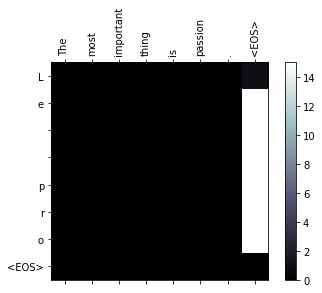

In [13]:
evaluateAndShowAttention(test2013[45])

input = There &apos;s only one thing that all the successful companies in the world have in common , only one : None were started by one person .
reference =  Toutes les sociétés qui réussissent dans le monde n&apos; ont qu&apos; une seule chose en commun , une seule chose : Aucune n&apos; ait été lancée par une seule personne .
output = I l   y   e n   a v a i t   q u e l q u e s  <EOS>


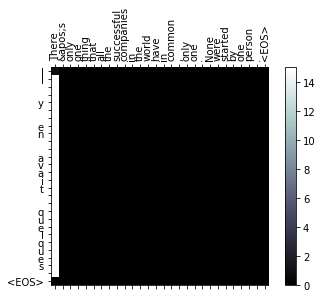

In [14]:
evaluateAndShowAttention(test2013[111])